# Animating Other Body Models With AMASS
In the basic [AMASS visualization notebook](01-AMASS_Visualization.ipynb), we presented code snippets to animate AMASS bodies
with [SMPL+H](http://mano.is.tue.mpg.de/) body model.
However, we can use AMASS to also animate other SMPL family body models; namely:
- Body only [SMPL](https://smpl.is.tue.mpg.de/)
- Hand only [MANO](http://mano.is.tue.mpg.de/)
- Expressive  Body, with Hands and Face [SMPL-X](https://smpl-x.is.tue.mpg.de/).

AMASS uses [human_body_prior](https://github.com/nghorbani/human_body_prior) python package to animate bodies.
The provided body model interface handles all SMPL body family models automatically and transparently.
That means you can pass a SMPL family model to the BodyModel class and in the forward call pass desired body parameters from AMASS;
e.g. load an instance of SMPL and only pass pose_body that won't articulate fingers.
The rest will be taken care of automatically by the code.
This tutorial shows a practical example to animate SMPL and SMPL-X bodies using AMASS.

In [2]:
# Preparing the environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from ipywidgets import interact_manual
from ipywidgets import IntSlider


import torch
import numpy as np

from human_body_prior.tools.omni_tools import copy2cpu as c2c
from os import path as osp

support_dir = '../support_data/'

In [4]:
# Choose the device to run the body model on.
comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
amass_npz_fname = osp.join(support_dir, 'github_data/amass_sample.npz') # the path to body data
bdata = np.load(amass_npz_fname)

num_betas = 16 # number of body parameters
num_dmpls = 8 # number of DMPL parameters

# you can set the gender manually and if it differs from data's then contact or interpenetration issues might happen
subject_gender = bdata['gender']

print('Data keys available:%s'%list(bdata.keys()))

print('The subject of the mocap sequence is  {}.'.format(subject_gender))

Data keys available:['poses', 'gender', 'mocap_framerate', 'betas', 'marker_data', 'dmpls', 'marker_labels', 'trans']
The subject of the mocap sequence is  male.


In [6]:
time_length = len(bdata['trans'])

body_parms = {
    'root_orient': torch.Tensor(bdata['poses'][:, :3]).to(comp_device), # controls the global root orientation
    'pose_body': torch.Tensor(bdata['poses'][:, 3:66]).to(comp_device), # controls the body
    'pose_hand': torch.Tensor(bdata['poses'][:, 66:]).to(comp_device), # controls the finger articulation
    'trans': torch.Tensor(bdata['trans']).to(comp_device), # controls the global body position
    'betas': torch.Tensor(np.repeat(bdata['betas'][:num_betas][np.newaxis], repeats=time_length, axis=0)).to(comp_device), # controls the body shape. Body shape is static
    'dmpls': torch.Tensor(bdata['dmpls'][:, :num_dmpls]).to(comp_device) # controls soft tissue dynamics
}

print('Body parameter vector shapes: \n{}'.format(' \n'.join(['{}: {}'.format(k,v.shape) for k,v in body_parms.items()])))
print('time_length = {}'.format(time_length))

Body parameter vector shapes: 
root_orient: torch.Size([601, 3]) 
pose_body: torch.Size([601, 63]) 
pose_hand: torch.Size([601, 90]) 
trans: torch.Size([601, 3]) 
betas: torch.Size([601, 16]) 
dmpls: torch.Size([601, 8])
time_length = 601


In [7]:
import trimesh
from body_visualizer.tools.vis_tools import colors
from body_visualizer.mesh.mesh_viewer import MeshViewer
from body_visualizer.tools.vis_tools import show_image

imw, imh = 1600, 1600
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

## SMPL-X

## AMASS for SMPL
First download [SMPL](https://smpl.is.tue.mpg.de/) body model and extract it to a desired location.
The PCA shape space of SMPL and SMPL+H are compatible, so betas and DMPLs can be used interchangeably.
Of course SMPL model does not support hand articulation, unlike SMPL+H. Hence, we cannot animate fingers of SMPL using AMASS.

In [9]:
from human_body_prior.body_model.body_model import BodyModel

bm_smpl_fname = osp.join(support_dir, 'body_models/smpl/neutral/SMPL_X_model_neutral.npz'.format(subject_gender))
# bm_smpl_fname = '/is/ps3/nghorbani/code-repos/amass/support_data/body_models/smpl/neutral/model.npz'

bm = BodyModel(bm_fname=bm_smpl_fname, num_betas=num_betas).to(comp_device)

faces = c2c(bm.f)
num_verts = bm.init_v_template.shape[1]

{'pose_body': torch.Size([601, 63]), 'betas': torch.Size([601, 16])}


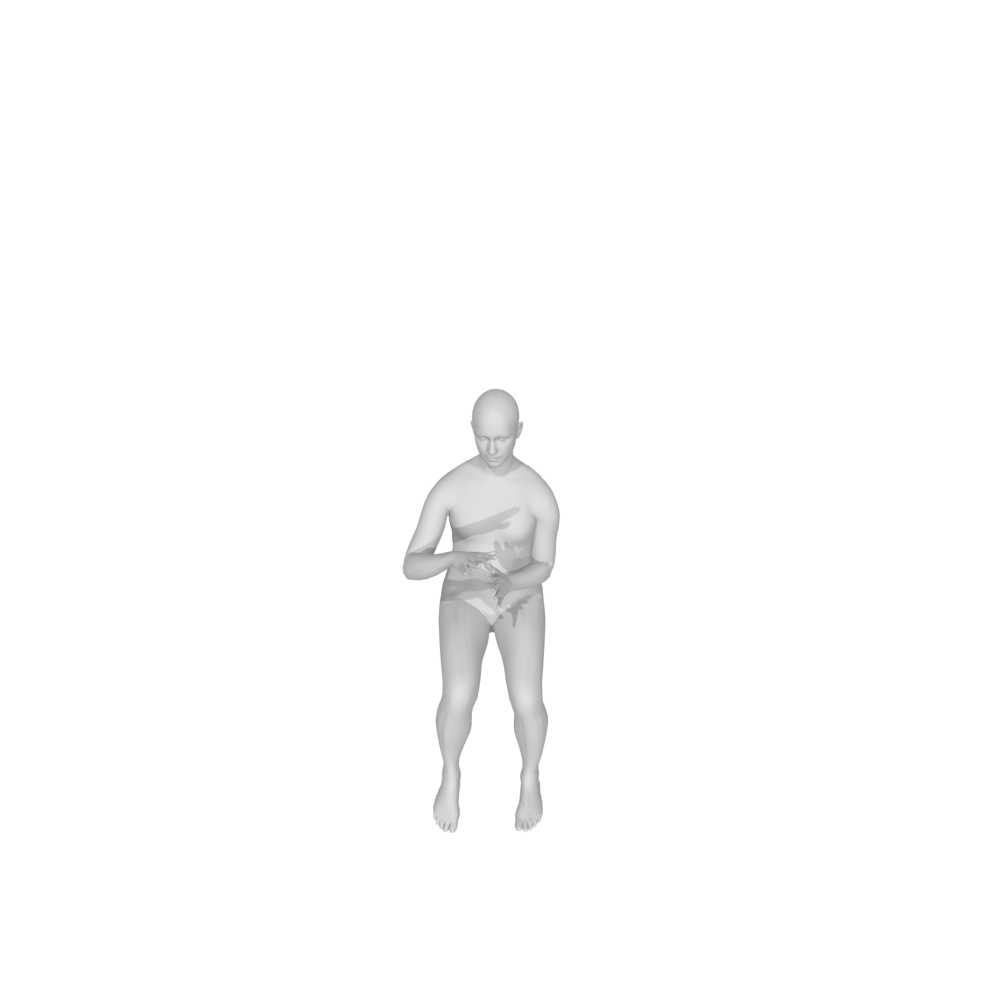

In [10]:
print({k:v.shape for k,v in body_parms.items() if k in ['pose_body', 'betas']})
body = bm(**{k:v.to(comp_device) for k,v in body_parms.items() if k in ['pose_body']})
body_mesh_wofingers = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (num_verts, 1)))
mv.set_static_meshes([body_mesh_wofingers])
body_image_wofingers = mv.render(render_wireframe=False)
show_image(body_image_wofingers)

Notice the flat hands due to inability of SMPL to articulate fingers. Due to this fact, we didn't pass pose_hand parameters neither.

## AMASS for SMPL-X
First obtain [SMPL-X](https://smpl-x.is.tue.mpg.de) body model and extract it at a desired location.
The PCA shape space of SMPL-X and SMPL+H do not correspond, so we cannot use the shape,
i.e. betas, nor the soft tissue dynamics, i.e. DMPLs, from AMASS on SMPL-X.
However,  we can still pose the body model using AMASS parameters.
SMPL-X has more joints than the SMPLH model because of the eye balls and jaw joints, hence we cannot animate jaw and eye balls using AMASS.

In [11]:
from human_body_prior.body_model.body_model import BodyModel

bm_smplx_fname = osp.join(support_dir, 'body_models/smplx/neutral/SMPLX_NEUTRAL_2020.npz'.format(subject_gender))

bm = BodyModel(bm_fname=bm_smplx_fname, num_betas=num_betas).to(comp_device)

faces = c2c(bm.f)
num_verts = bm.init_v_template.shape[1]

{'pose_body': torch.Size([601, 63]), 'pose_hand': torch.Size([601, 90]), 'betas': torch.Size([601, 16])}


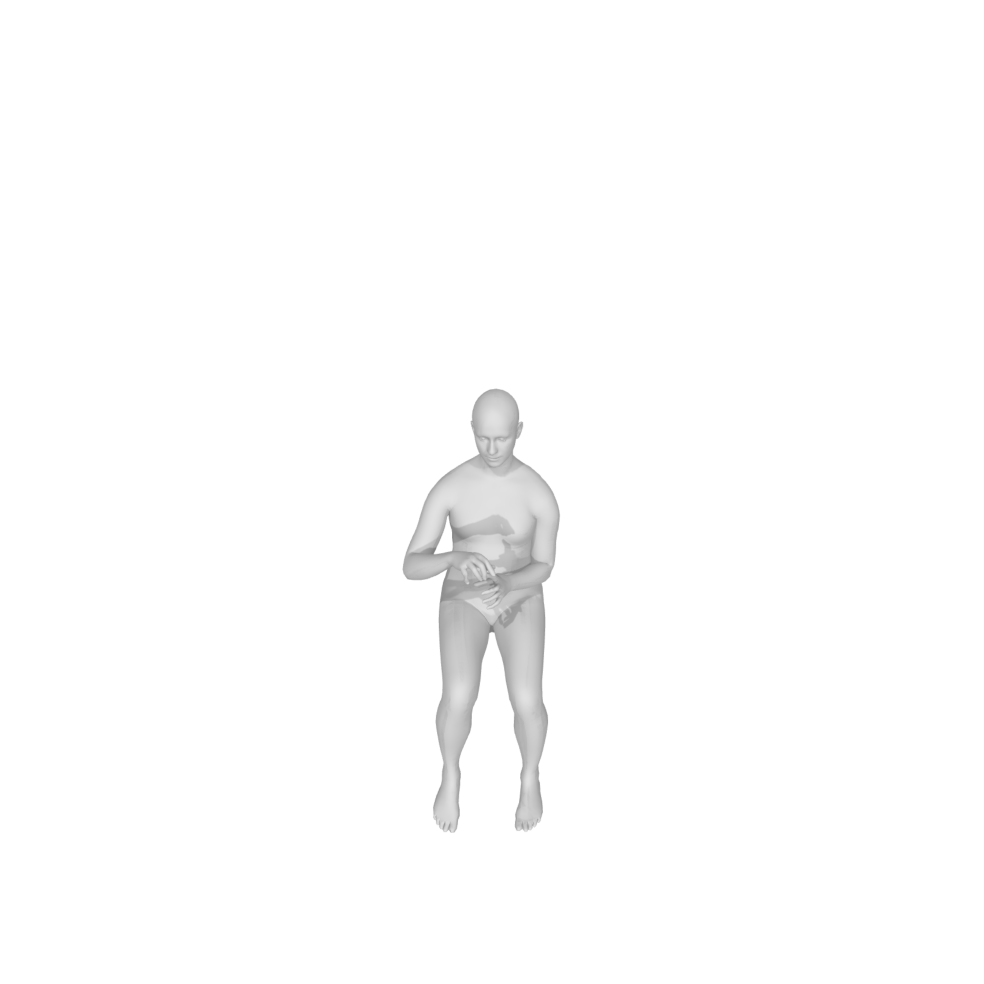

In [12]:
print({k:v.shape for k,v in body_parms.items() if k in ['pose_body', 'pose_hand', 'betas']})
body = bm(**{k:v.to(comp_device) for k,v in body_parms.items() if k in ['pose_body', 'pose_hand']})
body_mesh_wfingers = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (num_verts, 1)))
mv.set_static_meshes([body_mesh_wfingers])
body_image_wfingers = mv.render(render_wireframe=False)
show_image(body_image_wfingers)

You won't see a perfect match with original SMPL+H body because the shape is not taken into account with the above body.
SMPL+H and SMPLx body parameters are not fully compatible.
For next releases of AMASS we intend to include more model types from SMPL family.